# Cluster queries
Use query features to find groupings and compare to assigned labels
1. Get query lengths
2. Describe df
3. Make EDA report
4. Normalize features
5. Apply k-means 
6. Evaluate clusters

Variables:
- Categorical (search strings, label strings)
- Continuous (search features)

Clustering algorithms 
- K-Means

To do:
- [ ] merge Search Terms in Open Refine
- [ ] finish labeling data (n=850)
- [ ] split data and predict labels
- [ ] find best number of clusters

Resources:
- [Clustering pipeline and evaluation](https://realpython.com/k-means-clustering-python/)
- [Finding the best number of clusters](https://www.datacamp.com/tutorial/k-means-clustering-python)


In [10]:
import math
import nltk
import pandas as pd
from ydata_profiling import ProfileReport
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler, normalize
from sklearn.cluster import KMeans

Load the data

In [2]:
df = pd.read_excel('./search-terms-20120901-20160901.xlsx',sheet_name=0)
df['Search_Term'] = df['Search_Term'].astype(str) # queries as strings
df = df.drop(columns=['Link','Notes','Time_After_Search']) # remove url, annotation notes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Search_Term                   5000 non-null   object 
 1   Label                         635 non-null    object 
 2   Total_Unique_Searches         5000 non-null   int64  
 3   Results_Pageviews_Per_Search  5000 non-null   float64
 4   Percent_Search_Exits          5000 non-null   float64
 5   Percent_Search_Refinements    5000 non-null   float64
 6   Search_Duration_Seconds       5000 non-null   int64  
 7   Average_Search_Depth          5000 non-null   float64
dtypes: float64(4), int64(2), object(2)
memory usage: 312.6+ KB


Get query lengths

In [3]:
def query_len(term):
    """Get search tokens per query"""
    test_query = term
    search_terms = nltk.word_tokenize(test_query)
    return len(search_terms)

df['Query_Length'] = df['Search_Term'].apply(query_len)

Describe df

In [4]:
df.describe()
# df.info()
# df.head()

Total_Unique_Searches  Results_Pageviews_Per_Search  \
count            5000.000000                   5000.000000   
mean              162.838400                      3.229476   
std               383.035716                      1.040815   
min                37.000000                      1.000000   
25%                49.000000                      2.510000   
50%                72.000000                      3.090000   
75%               139.000000                      3.810000   
max             10148.000000                     12.980000   

       Percent_Search_Exits  Percent_Search_Refinements  \
count           5000.000000                 5000.000000   
mean               0.265725                    0.193518   
std                0.127769                    0.090398   
min                0.000000                    0.000000   
25%                0.189200                    0.136400   
50%                0.246750                    0.179200   
75%                0.312600                    0.235300   
max                1.000000                    0.916700   

       Search_Duration_Seconds  Average_Search_Depth  Query_Length  
count              5000.000000           5000.000000   5000.000000  
mean                298.954800              3.287012      2.092600  
std                 122.000572              1.599668      2.326609  
min                   0.000000              0.000000      1.000000  
25%                 222.000000              2.260000      1.000000  
50%                 288.000000              3.100000      1.000000  
75%                 358.250000              4.030000      2.000000  
max                1876.000000             20.610000     28.000000

Make EDA report

In [6]:
profile = ProfileReport(df, title="Query Log Profiling Report");
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [7]:
profile.to_file("cluster_queries_report.html")

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Determine distributions of the features of interest

OPTION 1: manually define scaling
- Normal distributions (5) - normalize
    - Results_Pageviews_Per_Search
    - Percent_Search_Exits
    - Percent_Search_Refinements
    - Search_Duration_Seconds
    - Average_Search_Depth 
- Right-tailed distributions (2) - log transform
    - Total_Unique_Searches
    - Query_Length
- No specific distributions

OPTION 2: apply scaler to df
- normalize (min-max)
- standardize (centered on 0)


In [8]:
# OPTION 1

# def log_transform(x):
#     return np.log(x + 1)

# df_features['Total_Unique_Searches_norm'] = df_features['Total_Unique_Searches'].apply(log_transform)


# df_features['Query_Length_norm'] = (df_features['Query_Length'] - df_features['Query_Length'].mean()
#                            ) / df_features['Query_Length'].std()

# def create_quantiles(x, q):
#     return pd.qcut(x, q, labels=False, duplicates='drop')

# df_features['Query_Length_norm'] = create_quantiles(df_features['Query_Length'],3)

# sns.distplot(df_features['Query_Length_norm']) # check the new distribution

In [26]:
# OPTION 2

df_features = df[['Total_Unique_Searches', 
                  'Query_Length',
                  'Results_Pageviews_Per_Search',
                  'Percent_Search_Exits',
                  'Percent_Search_Refinements',
                  'Search_Duration_Seconds',
                  'Average_Search_Depth']]

# scaler = MinMaxScaler() # normalize so all data are between 0-1
scaler = StandardScaler() # z-score normalization; assumes all observations are normal, centered on 0

array_scaled = scaler.fit_transform(df_features)
# array_scaled = normalize(df_features)
array_scaled


array([[26.07109426, -0.46965753, -1.48886366, ..., -0.89190425,
         1.11523089,  0.91464851],
       [22.66898249, -0.0398044 , -0.52798162, ..., -0.76578284,
         0.86110831,  0.62080823],
       [19.79167845, -0.46965753,  0.69233857, ..., -0.05330754,
         0.2217031 ,  0.21443338],
       ...,
       [-0.32856201, -0.0398044 , -0.08597588, ...,  0.05289996,
        -0.53246715, -0.16068187],
       [-0.32856201, -0.46965753, -0.37424049, ...,  0.49321855,
         0.38565315,  0.27695259],
       [-0.32856201, -0.46965753,  0.63468565, ..., -0.22036308,
        -0.65542969, -0.87340083]])

Create and plot clusters

In [36]:
kmeans = KMeans(init="random", n_clusters=10, n_init=10, max_iter=300, random_state=42)
kmeans.fit(array_scaled)

# The lowest SSE value
kmeans.inertia_

# Final locations of the centroid
kmeans.cluster_centers_

# The number of iterations required to converge
kmeans.n_iter_

# The labels
kmeans.labels_[:5]


array([8, 8, 8, 8, 8], dtype=int32)

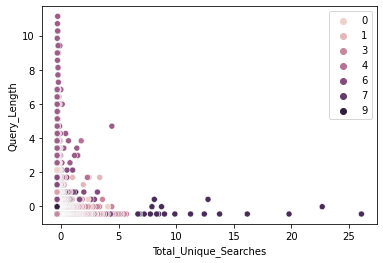

In [37]:
df_scaled = pd.DataFrame(array_scaled, columns = df_features.columns) # array back to df
df_scaled

sns.scatterplot(data = df_scaled, x = 'Total_Unique_Searches', y = 'Query_Length', hue = kmeans.labels_);


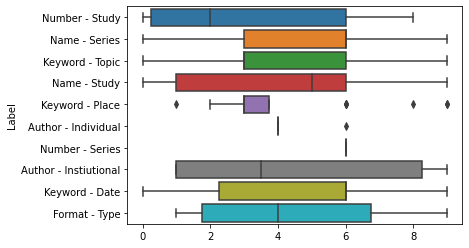

In [39]:
sns.boxplot(x = kmeans.labels_, y = df['Label']);
